<a href="https://colab.research.google.com/github/MGuvenc/Novelty/blob/main/test_novelty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import joblib
from sklearn.ensemble import IsolationForest

In [7]:
sql_t = '''
     SELECT * FROM xxxx.xxxxx_kume
     '''
dsn_tns = cx_Oracle.makedsn('xx.xx.xxx.xx', 'xxxx', service_name='xxxxxxx')
conn = cx_Oracle.connect(user=r'xxxxxxxxxx', password='xxxxxxx', dsn=dsn_tns)
c = conn.cursor()

In [8]:
try:
    test = pd.read_sql_query(sql_t, conn)
    orig_df_test = test.copy()

    conn.close()
    yazdir('Veri Setleri Okundu.')
except Exception as e:
    yazdir('ERR#3 : Dosya açılma sırasında hata oldu.'+ str(e))

In [ ]:
test['TARIH'] = test[('MUHASEBE_TR')].values.astype("float64")
test.rename(columns={'BAKIYE': 'GIDER'}, inplace=True)
id = test.groupby('KUME')
#id_t = [group for _, group in test.groupby('KUME')]


normal_data = pd.DataFrame()
anomali_data = pd.DataFrame()

In [9]:
models = joblib.load('models.pkt')

In [38]:
def test(id):
  for unique_id, group_data in id:
    if unique_id in models:
      model = models[unique_id]
      # predictions = model.predict(group_data[['TARIH', 'GİDER']])
      scores = model.decision_function(group_data[['TARIH', 'GİDER']])
      normal = group_data[scores > -0.15] # predict scores == 1
      normal_data = pd.concat([normal_data, normal], ignore_index=True)
      anomali = group_data[scores <= -0.15] # predict scores  == -1
      anomali_data = pd.concat([anomali_data, anomali], ignore_index=True)
    else:
      print(f"Eğitilmemiş id bulundu: {unique_id}")

In [ ]:
with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
    executor.map(test, id)

In [ ]:
normal_data['TARIH'] = pd.to_datetime(normal_data['TARIH'])
anomali_data['TARIH'] = pd.to_datetime(anomali_data['TARIH'])

In [21]:
sql = '''
     SELECT * FROM xxxx.xxxxxx_temizlenmis
     '''

dsn_tns = cx_Oracle.makedsn('xx.xx.xxx.xx', 'xxxx', service_name='xxxxxxx')
conn = cx_Oracle.connect(user=r'xxxxxxxxxx', password='xxxxxxx', dsn=dsn_tns)
c = conn.cursor()

In [ ]:
try:
  data = pd.read_sql_query(sql, conn)
  orig_data = data.copy()

  conn.close()
  yazdir(' Veri Setleri Okundu.')
except Exception as e:
  yazdir('ERR#3 : Dosya açılma sırasında hata oldu.'+ str(e))

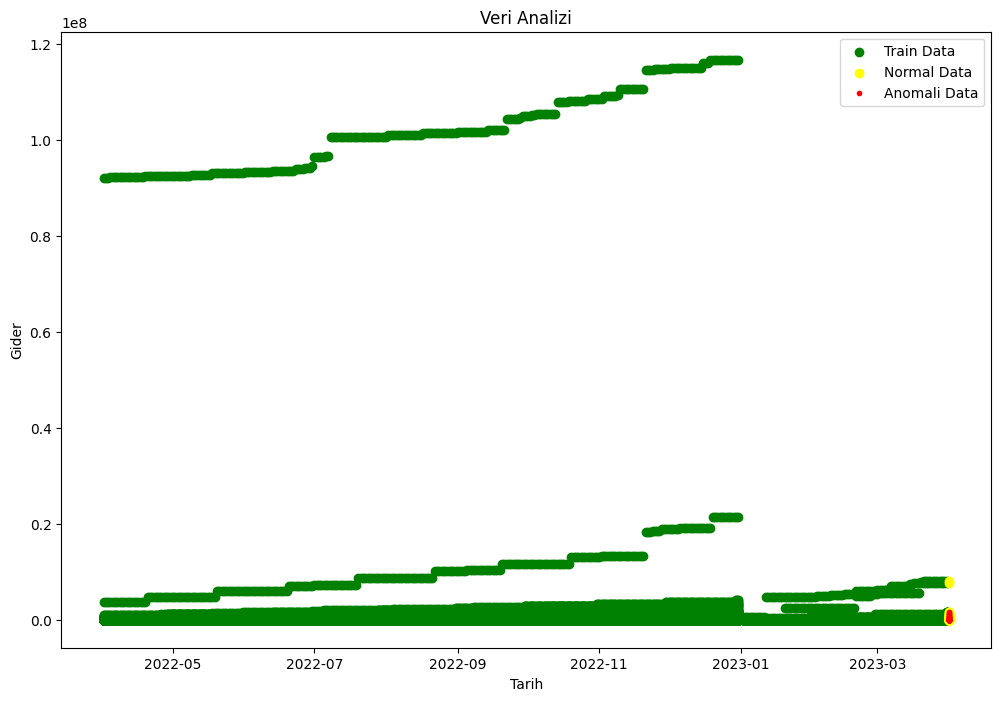

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.scatter(data['MUHASEBE_TR'], data['BAKIYE'], c='green', label='Train Data')
plt.scatter(normal_data['TARIH'], normal_data['GIDER'], c='yellow', label='Normal Data')
plt.scatter(anomali_data['TARIH'], anomali_data['GIDER'], c='red', marker='.', label='Anomali Data')

plt.title('Veri Analizi')
plt.xlabel('Tarih')
plt.ylabel('Gider')
plt.legend()
plt.show()

In [39]:
normal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  227 non-null    int64         
 1   tarih       227 non-null    datetime64[ns]
 2   sube        227 non-null    int64         
 3   gider_turu  227 non-null    int64         
 4   id          227 non-null    int64         
 5   GIDER       227 non-null    float64       
 6   TARIH       227 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 12.5 KB


In [40]:
anomali_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  39 non-null     int64         
 1   tarih       39 non-null     datetime64[ns]
 2   sube        39 non-null     int64         
 3   gider_turu  39 non-null     int64         
 4   id          39 non-null     int64         
 5   GIDER       39 non-null     float64       
 6   TARIH       39 non-null     float64       
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 2.3 KB
